# INM702: Task 1

This task is about classifying images of written numbers from the MNIST dataset. We develop a neural network using basic libraries such as NumPy, without resorting to ready-made functions from TensorFlow, Keras or PyTorch.

The work presented here is part of the coursework of the INM702 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM702).

**Implementation Overview**
- Activation : Sigmoid, ReLU, Softmax
- Regularisation : Dropout, L1 (Lasso), L2 (Ridge)
- Fully Parametrisable Neural Network Class
- Optimiser : Batch Gradient Descent, Stochastic Gradient Descent, Mini-Batch Gradient Descent, Adaptive Moment Estimation
- Different Neural Network Architectures/Parameters

### Import Libraries and Load MNIST

We import the relevant libraries to create our neural network. We use TensorFlow only to import the MNIST dataset. One-hot encoding is performed on the data. We also normalise the data.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

# Use TensorFlow to load MNIST (easy method)
import tensorflow.keras.datasets.mnist as mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

11490434/11490434 [==============================] - 1s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [2]:
# Length * Width
image_pixels = X_train.shape[1] * X_train.shape[1]

# Convert training and test sets to 2-D arrays, and normalise
X_train = X_train.reshape((X_train.shape[0], image_pixels)).T / 255.0
X_test = X_test.reshape((X_test.shape[0], image_pixels)).T / 255.0

# One-hot encoder function
def one_hot_encoder(labels):
    num_classes = np.max(labels) + 1
    one_hot_labels = np.eye(num_classes)[labels]
    return one_hot_labels

# Convert to one-hot encoded arrays
y_train_one_hot = one_hot_encoder(y_train).T
y_test_one_hot = one_hot_encoder(y_test).T

X_train.shape, X_test.shape, y_train_one_hot.shape, y_test_one_hot.shape

((784, 60000), (784, 10000), (10, 60000), (10, 10000))

### **(a,b)** Sigmoid, ReLU and Softmax Layers

We create functions for the Sigmoid, ReLU and Softmax layers. Each can be used for forward pass and backward pass.

In [3]:
# Sigmoid with derivative
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    ds = s * (1.0 - s)
    return s, ds

# ReLU with derivative
def relu(x):
    return x * (x >= 0), (x > 0).astype(float)

# Softmax with derivative
def softmax(vec):
    s = np.exp(vec) / np.exp(vec).sum()
    return s, s * (np.eye(s.size) - s.reshape(-1, 1))

# Softmax with correction for underflow/overflow (and derivative)
def softmax_corrected(vec):
    vec = vec - np.max(vec)
    s = np.exp(vec) / np.exp(vec).sum()
    return s, s * (np.eye(s.size) - s.reshape(-1, 1))

Sigmoid/Derivative



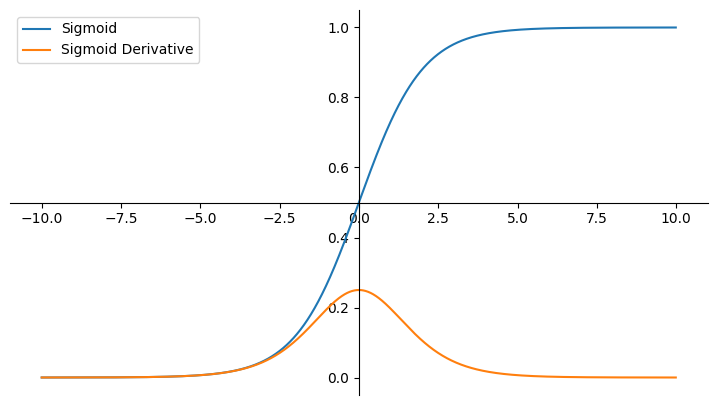

ReLU/Derivative


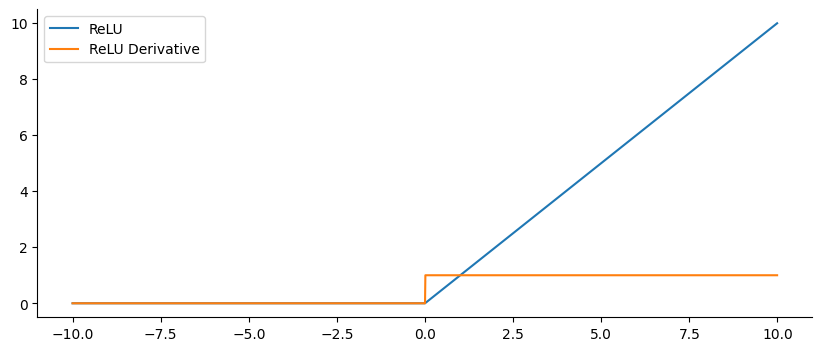

In [4]:
# Set range of input values for Sigmoid and ReLU
x = np.arange(-10, 10, 0.01)

# Generate Sigmoid/Derivative Plot
print("Sigmoid/Derivative\n")

fig1, ax1 = plt.subplots(figsize=(9, 5))

ax1.spines["left"].set_position("center")
ax1.spines["bottom"].set_position("center")
ax1.spines["top"].set_color("none")
ax1.spines["right"].set_color("none")

ax1.plot(x, sigmoid(x)[0], label = "Sigmoid")
ax1.plot(x, sigmoid(x)[1], label = "Sigmoid Derivative")
ax1.legend(loc = "upper left")
plt.show()

# Generate ReLU/Derivative Plot
print("ReLU/Derivative")

fig2, ax2 = plt.subplots(figsize = (10, 4))

ax2.spines["top"].set_color("none")
ax2.spines["right"].set_color("none")

ax2.plot(x, relu(x)[0], label = "ReLU")
ax2.plot(x, relu(x)[1], label = "ReLU Derivative")
ax2.legend(loc = "upper left")
plt.show()

In [5]:
# Presenting the difference between the two softmax functions

print(softmax([1,2000,-535])[0])
print(softmax_corrected([1,2000,-535])[0])

[ 0. nan  0.]
[0. 1. 0.]


### Set Random Seeds

In [6]:
# Random Seed and Seed Choice

randomer = 50
random.seed(randomer)
np.random.seed(randomer)

### (c,d,e) Neural Network Class

We create a neural network class that takes 6 parameters, which are detailed below. The class can handle multiple layers, dropout, L1, and L2 regularisation. (Batch) Gradient Descent, Stochastic Gradient Descent, Mini-Batch Gradient Descent and Adaptive Moment Estimation (Adam) are the optimisers.

When using the .train() function to train your chosen model:

For Batch Gradient Descent, you must set the following: batch_size = None, optimizer = "gd"

For Stochastic Gradient Descent, you must set the following: batch_size = 1, optimizer = "mini_batch"

For Mini-Batch Gradient Descent, you must set the following: batch_size = {your chosen size}, optimizer = "mini_batch"

For Adam, you must set the following: optimizer = "adam"

In [7]:
# Neural Network Class

class NeuralNetwork:
    """
    Neural Network Class

    Parameters:
    - layer_sizes: A list containing first the input size, and lastly the output size. Hidden layers can optionally be added
      in between. For example [10, 128, 64, 2] for input of size 10, two hidden layers of size 128 and 64 respectively,
      and output of size 2.
    - activation_function: Activation function used in every layer.
    - dropout_rate: The probability of keeping a neuron inactive during dropout. A float between 0 and 1, where 0 means no dropout.
    - l1: L1 regularisation factor.
    - l2: L2 regularisation factor.
    - random_state: Seed used to generate the random weights. If no seed is specified, the seed set as 'randomer' will be used.
    """
    def __init__(self, layer_sizes, activation_function = relu, dropout_rate = 0, l1 = 0, l2 = 0, random_state = randomer):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation_function = activation_function
        self.random_state = random_state
        self.parameters = self.initialise_parameters()
        self.dropout_rate = dropout_rate
        self.dropout_masks = None
        self.l1 = l1
        self.l2 = l2
        self.Vdw, self.Vdb, self.Sdw, self.Sdb = self.initialise_adam()

    # Forward propagation
    def forward_propagation(self, X, is_training = True):
        # Store input values at layer and create dictionary for dropout (if used)
        cache = {"A0": X}
        self.dropout_masks = {}

        # Start from the beginning of the neural network
        for l in range(1, self.num_layers):
            # Get weights and bias at layer, and retrieve activation from the previous layer
            Wl, bl = self.parameters[f"W{l}"], self.parameters[f"b{l}"]
            Al_prev = cache[f"A{l - 1}"]

            # Calculate weighted sum with bias at layer
            Zl = np.dot(Wl, Al_prev) + bl

            # Apply dropout during training, excluding the output layer
            if is_training and self.dropout_rate > 0 and l < self.num_layers - 1:
                dropout_mask = (np.random.rand(*Zl.shape) < self.dropout_rate) / (1 - self.dropout_rate)
                self.dropout_masks[f"mask{l}"] = dropout_mask
                Zl *= dropout_mask

            # Apply transformation function to weighted sum
            Al = self.activation_function(Zl)[0]

            # Store weighted sum and activation
            cache[f"Z{l}"] = Zl
            cache[f"A{l}"] = Al

        return Al, cache
    
    # Backpropagation
    def backpropagation(self, A, Y, cache):
        m = Y.shape[1]
        # Create dictionary to store the gradients
        gradients = {}
        
        # Compute errors at layer
        dZ = A - Y
        # Start from end of neural network
        for l in reversed(range(1, self.num_layers)):
            # Get weights at layer, and retrieve activation from previous layer
            Al_prev = cache[f"A{l - 1}"]
            Wl = self.parameters[f"W{l}"]

            # Apply dropout during backpropagation
            if f"mask{l}" in self.dropout_masks:
                dZ *= self.dropout_masks[f"mask{l}"]
            
            # Add weight and bias gradients to dictionary
            gradients[f"dW{l}"] = (np.dot(dZ, Al_prev.T) / m) + (self.l1 / m) * np.sign(Wl) + (self.l2 / m) * Wl
            gradients[f"db{l}"] = np.sum(dZ, axis = 1, keepdims = True) / m
            
            # Compute derivative using activation function
            dZ = np.dot(Wl.T, dZ) * self.activation_function(Al_prev)[1]

        return gradients
        
    # Initialise weights
    def initialise_parameters(self):
        # Use random seed defined in the class parameters
        np.random.seed(self.random_state)
        # Create dictionary to store the weights
        parameters = {}
        # Go over each layer and create random weights
        for l in range(1, self.num_layers):
            # Normal distribution with mean 0 and standard deviation 0.01
            parameters[f"W{l}"] = np.random.randn(self.layer_sizes[l], self.layer_sizes[l - 1]) * 0.01
            parameters[f"b{l}"] = np.zeros((self.layer_sizes[l], 1))
        return parameters
    
    
    # Initialise Adam optimiser (which will be used if selected as the optimiser)
    def initialise_adam(self):
        # Variables to store moving averages of the gradients and square of gradients
        self.vdW, self.vdb, self.sdW, self.sdb = {},{},{},{}
        
        # Start from beginning of neural network
        for l in range(1, self.num_layers):
            self.vdW [f"vdW{l}"] = np.zeros_like(self.parameters[f"W{l}"])
            self.vdb [f"vdb{l}"] = np.zeros_like(self.parameters[f"b{l}"])
            self.sdW [f"sdW{l}"] = np.zeros_like(self.parameters[f"W{l}"])
            self.sdb [f"sdb{l}"] = np.zeros_like(self.parameters[f"b{l}"])
        
        return self.vdW, self.vdb, self.sdW, self.sdb
    

    # Categorical cross-entropy loss function
    def compute_categorical_cross_entropy_loss(self, A, Y):
        m = Y.shape[1]
    
        # Clip probabilities to avoid log(0) issues
        epsilon = 1e-15
        A = np.clip(A, epsilon, 1 - epsilon)
    
        # Compute categorical cross-entropy loss
        loss = -np.sum(Y * np.log(A)) / m
    
        return loss
    
    # Categorical cross-entropy loss function adjusted for L1/L2 regularisation
    def compute_cost_with_regularisation(self, A, Y):
        m = Y.shape[1]
        # Cross-entropy loss without regularisation
        cross_entropy_loss = self.compute_categorical_cross_entropy_loss(A, Y)

        # Compute L1 and L2 regularisation terms for weights
        l1_regularisation = 0
        l2_regularisation = 0
        for l in range(1, self.num_layers):
            l1_regularisation += np.sum(np.abs(self.parameters[f"W{l}"]))
            l2_regularisation += np.sum(np.square(self.parameters[f"W{l}"]))
        
        # Calculate the total cost with regularisation
        reg_cost = cross_entropy_loss + (self.l1 / (2 * m)) * l1_regularisation + (self.l2 / (2 * m)) * l2_regularisation
        return reg_cost, cross_entropy_loss
        
    # Accuracy function
    def compute_accuracy(self, A, Y):
        # Define the predicted labels
        predicted_labels = np.argmax(A, axis = 0)
        # Define the true labels
        true_labels = np.argmax(Y, axis = 0)
        return np.sum(predicted_labels == true_labels) / len(true_labels)
    
    # Function to train data, with epochs, learning rate, optimiser, and batch size as parameters
    def train(self, X, Y, num_epochs = 50, learning_rate = 0.1, optimizer = "mini_batch", batch_size = 32):
        # Save accuracy and losses to lists
        accuracies = []
        losses = []

        m = X.shape[1]

        # Loop over every epoch
        for epoch in range(num_epochs):
            # Shuffle the data for each epoch
            if batch_size and batch_size < m:
                # Set random seed and get random indices
                np.random.seed(self.random_state)
                indices = np.random.permutation(m)
                # Shuffle data
                X_shuffled = X[:, indices]
                Y_shuffled = Y[:, indices]
            else:
                X_shuffled = X
                Y_shuffled = Y

            # Loop over mini-batches (if any)
            for i in range(0, m, batch_size or m):
                # Create mini-batch
                X_mini_batch = X_shuffled[:, i:i + batch_size] if batch_size else X_shuffled
                Y_mini_batch = Y_shuffled[:, i:i + batch_size] if batch_size else Y_shuffled

                # Forward propagation
                A, cache = self.forward_propagation(X_mini_batch)

                # Compute loss
                loss, cross_entropy_loss = self.compute_cost_with_regularisation(A, Y_mini_batch)
                
                # Compute accuracy
                accuracy = self.compute_accuracy(A, Y_mini_batch)

                # Backpropagation
                gradients = self.backpropagation(A, Y_mini_batch, cache)

                # Update weights using the specified optimiser
                if optimizer == "gd":
                    self.update_parameters_gd(gradients, learning_rate)
                    
                elif optimizer == "mini_batch":
                    self.update_parameters_mini_batch(gradients, learning_rate, len(X_mini_batch[1]))
                    
                elif optimizer == "adam":
                    self.update_parameters_adam(gradients, learning_rate)

            # Output epoch number, accuracy, and loss values
            if (self.l1 == 0) and (self.l2 == 0):
                print(f"Epoch {epoch}, Accuracy: {round(accuracy * 100, 4)}%, Loss: {round(cross_entropy_loss, 4)}")
                # Append loss value to list
                losses.append(cross_entropy_loss)
            else:
                print(f"Epoch {epoch}, Accuracy: {round(accuracy * 100, 4)}%, Loss after L1/L2: {round(loss, 4)}")
                # Append loss value to list
                losses.append(loss)

            # Append accuracy value to list
            accuracies.append(accuracy)

        return accuracies, losses

    # Update weights using Gradient Descent
    def update_parameters_gd(self, gradients, learning_rate):
        # Gradient descent
        for l in range(1, self.num_layers):
            self.parameters[f"W{l}"] -= learning_rate * gradients[f"dW{l}"]
            self.parameters[f"b{l}"] -= learning_rate * gradients[f"db{l}"]

    # Update weights using Mini-Batch Gradient Descent (or Stochastic Gradient Descent with 'batch_size' = 1)
    def update_parameters_mini_batch(self, gradients, learning_rate, mini_batch_size):
        # Gradient descent with mini-batch
        for l in range(1, self.num_layers):
            self.parameters[f"W{l}"] -= learning_rate * gradients[f"dW{l}"] / mini_batch_size
            self.parameters[f"b{l}"] -= learning_rate * gradients[f"db{l}"] / mini_batch_size
    
    # Update weights using Adam
    def update_parameters_adam(self, gradients, learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-9):
        # Start from beginning of neural network
        for l in range(1, self.num_layers):
            # Exponentially weighted average of past gradients
            self.vdW[f"vdW{l}"] = beta1 * self.vdW[f"vdW{l}"] + (1 - beta1) * gradients[f"dW{l}"]
            self.vdb[f"vdb{l}"] = beta1 * self.vdb[f"vdb{l}"] + (1 - beta1) * gradients[f"db{l}"]
            # Exponentially weighted average of the squares of past gradients
            self.sdW[f"sdW{l}"] = beta2 * self.sdW[f"sdW{l}"] + (1 - beta2) * np.square(gradients[f"dW{l}"])
            self.sdb[f"sdb{l}"] = beta2 * self.sdb[f"sdb{l}"] + (1 - beta2) * np.square(gradients[f"db{l}"])

            # Bias correction
            vdW_corrected = self.vdW[f"vdW{l}"] / (1 - beta1)
            vdb_corrected = self.vdb[f"vdb{l}"] / (1 - beta1)
            sdW_corrected = self.sdW[f"sdW{l}"] / (1 - beta2)
            sdb_corrected = self.sdb[f"sdb{l}"] / (1 - beta2)

            # Update weights
            self.parameters[f"W{l}"] -= learning_rate * vdW_corrected / (np.sqrt(sdW_corrected) + epsilon)
            self.parameters[f"b{l}"] -= learning_rate * vdb_corrected / (np.sqrt(sdb_corrected) + epsilon)
    
    # Function for making predictions
    def predict(self, X):
        # Predict using forward propagation
        predictions, _ = self.forward_propagation(X, is_training = False)
        return predictions
    
    # Function to generate a confusion matrix
    def confusion_matrix(self, true_labels, predicted_labels):
        # Identify number of classes
        num_classes = len(np.unique(true_labels))
        
        # Create matrix of zeroes of size (num_classes * num_classes)
        cm = np.zeros((num_classes, num_classes), dtype = int)
        
        # Fill in the confusion matrix appropriately
        for true, predicted in zip(true_labels, predicted_labels):
            cm[true, predicted] += 1

        return cm
    
    # Function to plot confusion matrix from 'confusion_matrix'
    def plot_confusion_matrix(self, cm, classes, fileidentity = ""):
        # Plot confusion matrix
        plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")

        # Add text annotations for each cell in the confusion matrix
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, str(cm[i, j]), ha = "center", va = "center", color = "white" if cm[i, j] > cm.max() / 2 else "black")

        plt.savefig(f"{fileidentity}confusion_matrix.pdf")
        plt.show()
    
    # Generate and plot confusion matrix from 'confusion_matrix' and 'plot_confusion_matrix', using the model
    def evaluate_confusion_matrix(self, X, Y, classes, fileidentity = ""):
        # Make predictions of test set (or otherwise) using the model
        predictions = self.predict(X)
        # Define the predicted labels
        predicted_labels = np.argmax(predictions, axis = 0)
        # Define the true labels
        true_labels = np.argmax(Y, axis = 0)
        
        # Create and plot confusion matrix
        cm = self.confusion_matrix(true_labels, predicted_labels)
        self.plot_confusion_matrix(cm, classes = classes, fileidentity = fileidentity)

        return cm

## Base Neural Network Model (**Model 1**)

### Hyperparameters

Set hyperparameters to be used in initial model.

In [8]:
dropout_rate = 0
activation_function = relu
num_epochs = 150
learning_rate = 0.1
optimizer = "gd"
batch_size = None
l1 = 0.1
l2 = 0.1

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, output_size]

### Train Base Neural Network Model (**Model 1**)

We train our neural network on our training set. We use the ReLU activation function, batch gradient descent, learning rate of 0.1 and no batch size. One hidden layer of 64 nodes is used here. L1 and L2 regularisation (elastic-net) each of strength 0.1 is used.

- Activation : ReLU
- Optimiser : Batch Gradient Descent
- Hidden layers : 1
- Epochs : 150
- Regularisation : L1 (Lasso) and L2 (Ridge)
- Learning rate : 0.1

In [9]:
# Define model and train neural network on training set

model = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, l1 = l1, l2 = l2, random_state = randomer)
history = model.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 13.0283%, Loss after L1/L2: 13.6719
Epoch 1, Accuracy: 16.0283%, Loss after L1/L2: 4.2529
Epoch 2, Accuracy: 18.635%, Loss after L1/L2: 3.6326
Epoch 3, Accuracy: 21.39%, Loss after L1/L2: 3.2939
Epoch 4, Accuracy: 24.3633%, Loss after L1/L2: 3.0597
Epoch 5, Accuracy: 27.8333%, Loss after L1/L2: 2.8838
Epoch 6, Accuracy: 31.0967%, Loss after L1/L2: 2.746
Epoch 7, Accuracy: 33.7983%, Loss after L1/L2: 2.6352
Epoch 8, Accuracy: 36.0667%, Loss after L1/L2: 2.5451
Epoch 9, Accuracy: 37.9933%, Loss after L1/L2: 2.4712
Epoch 10, Accuracy: 39.9283%, Loss after L1/L2: 2.4102
Epoch 11, Accuracy: 41.7567%, Loss after L1/L2: 2.3597
Epoch 12, Accuracy: 43.5633%, Loss after L1/L2: 2.3175
Epoch 13, Accuracy: 45.3833%, Loss after L1/L2: 2.282
Epoch 14, Accuracy: 47.1283%, Loss after L1/L2: 2.2516
Epoch 15, Accuracy: 48.7283%, Loss after L1/L2: 2.2252
Epoch 16, Accuracy: 50.2833%, Loss after L1/L2: 2.2017
Epoch 17, Accuracy: 51.5967%, Loss after L1/L2: 2.1805
Epoch 18, Accuracy: 52.8

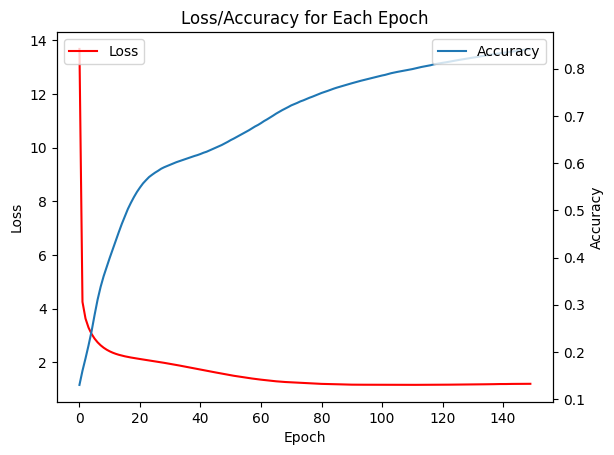

In [10]:
# Display loss and accuracy per epoch

# Loss
plt.plot(history[1], color = "red")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Accuracy
plt2 = plt.twinx()
plt2.plot(history[0])
plt.ylabel("Accuracy")
plt.title("Loss/Accuracy for Each Epoch")
plt2.legend(["Accuracy"], loc = "upper right")
plt.savefig("initial_model.pdf")
plt.show()

### Test Base Neural Network Model (Metrics)

We test our trained model on our test set. We compute the accuracy and loss, and generate a confusion matrix.

In [11]:
# Test the neural network
predictions = model.predict(X_test)

# Calculate accuracy and loss
accuracy = model.compute_accuracy(predictions, y_test_one_hot)
loss = model.compute_cost_with_regularisation(predictions, y_test_one_hot)[0]

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 85.37%
Loss: 1.1619


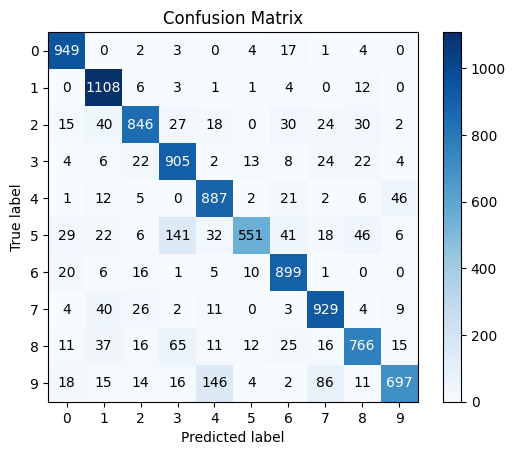

array([[ 949,    0,    2,    3,    0,    4,   17,    1,    4,    0],
       [   0, 1108,    6,    3,    1,    1,    4,    0,   12,    0],
       [  15,   40,  846,   27,   18,    0,   30,   24,   30,    2],
       [   4,    6,   22,  905,    2,   13,    8,   24,   22,    4],
       [   1,   12,    5,    0,  887,    2,   21,    2,    6,   46],
       [  29,   22,    6,  141,   32,  551,   41,   18,   46,    6],
       [  20,    6,   16,    1,    5,   10,  899,    1,    0,    0],
       [   4,   40,   26,    2,   11,    0,    3,  929,    4,    9],
       [  11,   37,   16,   65,   11,   12,   25,   16,  766,   15],
       [  18,   15,   14,   16,  146,    4,    2,   86,   11,  697]])

In [12]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names, fileidentity = "initial")

## (f) Evaluate Different Architectures/Parameters

We try changing the activation function between ReLU and sigmoid, using stochastic gradient descent, mini-batch gradient descent and Adam, and adjust the learning rate. We try changing the neural network architecture to include two hidden layers, and we introduce dropout, L1, and L2 regularisation in different models.

#### Model 2

We use the sigmoid activation function and mini-batch gradient descent. The neural network contains one hidden layer of 64 nodes. The batch size is 32, learning rate is 0.1 and we train on 150 epochs. No regularisation is applied.

- Activation : Sigmoid
- Optimiser : Mini-Batch Gradient Descent
- Hidden layers : 1
- Epochs : 150
- Learning rate : 0.1
- Batch size : 32

In [13]:
dropout_rate = 0
activation_function = sigmoid
num_epochs = 150
learning_rate = 0.1
optimizer = "mini_batch"
batch_size = 32
l1 = 0
l2 = 0

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, output_size]

##### Model 2 (Train)

In [14]:
# Define model and train neural network on training set

model_2 = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, l1 = l1, l2 = l2, random_state = randomer)
history_2 = model_2.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 3.125%, Loss: 2.3027
Epoch 1, Accuracy: 25.0%, Loss: 2.2706
Epoch 2, Accuracy: 53.125%, Loss: 2.1615
Epoch 3, Accuracy: 56.25%, Loss: 1.9056
Epoch 4, Accuracy: 56.25%, Loss: 1.5733
Epoch 5, Accuracy: 62.5%, Loss: 1.2861
Epoch 6, Accuracy: 65.625%, Loss: 1.0973
Epoch 7, Accuracy: 68.75%, Loss: 0.9761
Epoch 8, Accuracy: 71.875%, Loss: 0.889
Epoch 9, Accuracy: 81.25%, Loss: 0.8215
Epoch 10, Accuracy: 84.375%, Loss: 0.7683
Epoch 11, Accuracy: 84.375%, Loss: 0.7264
Epoch 12, Accuracy: 87.5%, Loss: 0.693
Epoch 13, Accuracy: 87.5%, Loss: 0.666
Epoch 14, Accuracy: 87.5%, Loss: 0.6435
Epoch 15, Accuracy: 87.5%, Loss: 0.6243
Epoch 16, Accuracy: 87.5%, Loss: 0.6074
Epoch 17, Accuracy: 87.5%, Loss: 0.5923
Epoch 18, Accuracy: 87.5%, Loss: 0.5784
Epoch 19, Accuracy: 87.5%, Loss: 0.5654
Epoch 20, Accuracy: 87.5%, Loss: 0.5531
Epoch 21, Accuracy: 90.625%, Loss: 0.5414
Epoch 22, Accuracy: 90.625%, Loss: 0.5304
Epoch 23, Accuracy: 93.75%, Loss: 0.52
Epoch 24, Accuracy: 93.75%, Loss: 0

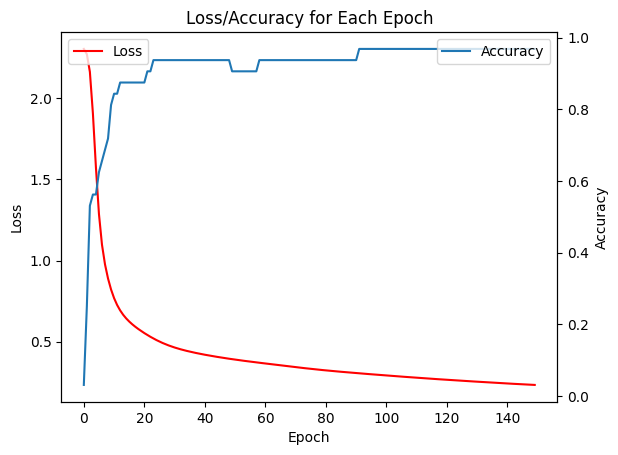

In [15]:
# Display loss and accuracy per epoch

# Loss
plt.plot(history_2[1], color = "red")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Accuracy
plt2 = plt.twinx()
plt2.plot(history_2[0])
plt.ylabel("Accuracy")
plt.title("Loss/Accuracy for Each Epoch")
plt2.legend(["Accuracy"], loc = "upper right")
plt.savefig("model_2.pdf")
plt.show()

##### Model 2 (Test)

In [16]:
# Test the neural network
predictions = model_2.predict(X_test)

# Calculate accuracy and loss
accuracy = model_2.compute_accuracy(predictions, y_test_one_hot)
loss = model_2.compute_cost_with_regularisation(predictions, y_test_one_hot)[0]

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 91.96%
Loss: 0.3421


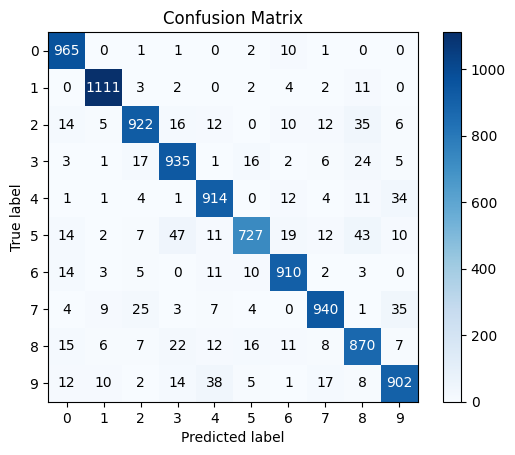

array([[ 965,    0,    1,    1,    0,    2,   10,    1,    0,    0],
       [   0, 1111,    3,    2,    0,    2,    4,    2,   11,    0],
       [  14,    5,  922,   16,   12,    0,   10,   12,   35,    6],
       [   3,    1,   17,  935,    1,   16,    2,    6,   24,    5],
       [   1,    1,    4,    1,  914,    0,   12,    4,   11,   34],
       [  14,    2,    7,   47,   11,  727,   19,   12,   43,   10],
       [  14,    3,    5,    0,   11,   10,  910,    2,    3,    0],
       [   4,    9,   25,    3,    7,    4,    0,  940,    1,   35],
       [  15,    6,    7,   22,   12,   16,   11,    8,  870,    7],
       [  12,   10,    2,   14,   38,    5,    1,   17,    8,  902]])

In [17]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model_2.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names, fileidentity = "model2")

#### Model 3

Proportion of nodes dropped for dropout regularisation is 50%. We use the ReLU activation function, mini-batch gradient descent, learning rate of 1 and batch size of 32. We use two hidden layers here each containing 64 nodes.

- Activation : ReLU
- Optimiser : Mini-Batch Gradient Descent
- Hidden layers : 2
- Epochs : 150
- Learning rate : 1
- Batch size : 32
- Dropout rate : 50%

In [18]:
dropout_rate = 0.5
activation_function = relu
num_epochs = 150
learning_rate = 1
optimizer = "mini_batch"
batch_size = 32
l1 = 0
l2 = 0

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, 64, output_size]

##### Model 3 (Train)

In [19]:
# Define model and train neural network on training set

model_3 = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, l1 = l1, l2 = l2, random_state = randomer)
history_3 = model_3.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 53.125%, Loss: 1.2479
Epoch 1, Accuracy: 71.875%, Loss: 0.7664
Epoch 2, Accuracy: 84.375%, Loss: 0.574
Epoch 3, Accuracy: 87.5%, Loss: 0.4501
Epoch 4, Accuracy: 90.625%, Loss: 0.3678
Epoch 5, Accuracy: 93.75%, Loss: 0.3243
Epoch 6, Accuracy: 96.875%, Loss: 0.2864
Epoch 7, Accuracy: 96.875%, Loss: 0.2533
Epoch 8, Accuracy: 96.875%, Loss: 0.2295
Epoch 9, Accuracy: 96.875%, Loss: 0.2153
Epoch 10, Accuracy: 96.875%, Loss: 0.2027
Epoch 11, Accuracy: 96.875%, Loss: 0.1962
Epoch 12, Accuracy: 96.875%, Loss: 0.1847
Epoch 13, Accuracy: 96.875%, Loss: 0.1795
Epoch 14, Accuracy: 96.875%, Loss: 0.1713
Epoch 15, Accuracy: 96.875%, Loss: 0.1663
Epoch 16, Accuracy: 96.875%, Loss: 0.1592
Epoch 17, Accuracy: 96.875%, Loss: 0.1531
Epoch 18, Accuracy: 96.875%, Loss: 0.1502
Epoch 19, Accuracy: 96.875%, Loss: 0.1473
Epoch 20, Accuracy: 96.875%, Loss: 0.1444
Epoch 21, Accuracy: 96.875%, Loss: 0.1406
Epoch 22, Accuracy: 96.875%, Loss: 0.1359
Epoch 23, Accuracy: 96.875%, Loss: 0.1327
Epoch 

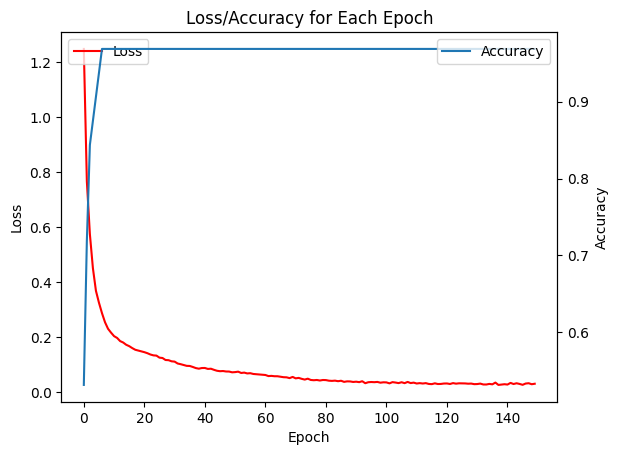

In [20]:
# Display loss and accuracy per epoch

# Loss
plt.plot(history_3[1], color = "red")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Accuracy
plt2 = plt.twinx()
plt2.plot(history_3[0])
plt.ylabel("Accuracy")
plt.title("Loss/Accuracy for Each Epoch")
plt2.legend(["Accuracy"], loc = "upper right")
plt.savefig("model_3.pdf")
plt.show()

##### Model 3 (Test)

In [21]:
# Test the neural network
predictions = model_3.predict(X_test)

# Calculate accuracy
accuracy = model_3.compute_accuracy(predictions, y_test_one_hot)
loss = model_3.compute_cost_with_regularisation(predictions, y_test_one_hot)[0]

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 95.3%
Loss: 0.9866


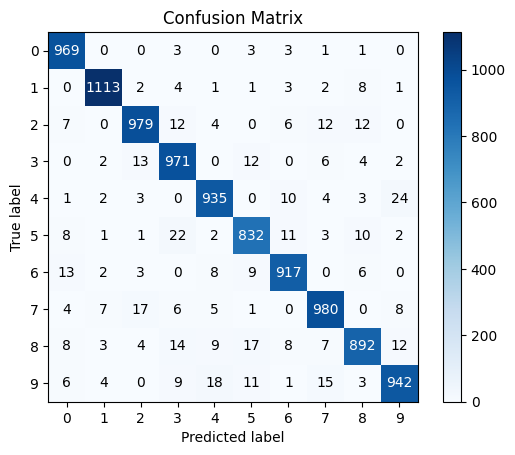

array([[ 969,    0,    0,    3,    0,    3,    3,    1,    1,    0],
       [   0, 1113,    2,    4,    1,    1,    3,    2,    8,    1],
       [   7,    0,  979,   12,    4,    0,    6,   12,   12,    0],
       [   0,    2,   13,  971,    0,   12,    0,    6,    4,    2],
       [   1,    2,    3,    0,  935,    0,   10,    4,    3,   24],
       [   8,    1,    1,   22,    2,  832,   11,    3,   10,    2],
       [  13,    2,    3,    0,    8,    9,  917,    0,    6,    0],
       [   4,    7,   17,    6,    5,    1,    0,  980,    0,    8],
       [   8,    3,    4,   14,    9,   17,    8,    7,  892,   12],
       [   6,    4,    0,    9,   18,   11,    1,   15,    3,  942]])

In [22]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model_3.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names, fileidentity = "model3")

#### Model 4

Here, we use no regularisation. The ReLU activation function is used, with the Adam optimiser. The batch size is 32 and the learning rate is 0.001. Two hidden layers of 64 nodes are used.

- Activation : ReLU
- Optimiser : Adam
- Hidden layers : 2
- Epochs : 150
- Learning rate : 0.001
- Batch size : 32

In [23]:
dropout_rate = 0
activation_function = relu
num_epochs = 150
learning_rate = 0.001
optimizer = "adam"
batch_size = 32
l1 = 0
l2 = 0

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, 64, output_size]

##### Model 4 (Train)

In [24]:
# Define model and train neural network on training set

model_4 = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, l1 = l1, l2 = l2, random_state = randomer)
history_4 = model_4.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 100.0%, Loss: 0.2006
Epoch 1, Accuracy: 100.0%, Loss: 0.1378
Epoch 2, Accuracy: 100.0%, Loss: 0.1127
Epoch 3, Accuracy: 100.0%, Loss: 0.0927
Epoch 4, Accuracy: 100.0%, Loss: 0.0825
Epoch 5, Accuracy: 100.0%, Loss: 0.0721
Epoch 6, Accuracy: 100.0%, Loss: 0.0579
Epoch 7, Accuracy: 100.0%, Loss: 0.0469
Epoch 8, Accuracy: 100.0%, Loss: 0.0415
Epoch 9, Accuracy: 100.0%, Loss: 0.0344
Epoch 10, Accuracy: 100.0%, Loss: 0.0298
Epoch 11, Accuracy: 100.0%, Loss: 0.0272
Epoch 12, Accuracy: 100.0%, Loss: 0.0251
Epoch 13, Accuracy: 100.0%, Loss: 0.0205
Epoch 14, Accuracy: 100.0%, Loss: 0.0194
Epoch 15, Accuracy: 100.0%, Loss: 0.0197
Epoch 16, Accuracy: 100.0%, Loss: 0.022
Epoch 17, Accuracy: 100.0%, Loss: 0.0177
Epoch 18, Accuracy: 100.0%, Loss: 0.0184
Epoch 19, Accuracy: 100.0%, Loss: 0.0179
Epoch 20, Accuracy: 100.0%, Loss: 0.0178
Epoch 21, Accuracy: 100.0%, Loss: 0.0198
Epoch 22, Accuracy: 100.0%, Loss: 0.0188
Epoch 23, Accuracy: 100.0%, Loss: 0.02
Epoch 24, Accuracy: 100.0%, L

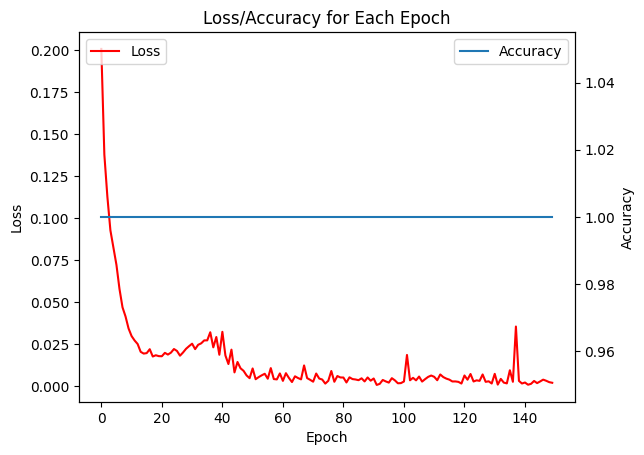

In [25]:
# Display loss and accuracy per epoch

# Loss
plt.plot(history_4[1], color = "red")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Accuracy
plt2 = plt.twinx()
plt2.plot(history_4[0])
plt.ylabel("Accuracy")
plt.title("Loss/Accuracy for Each Epoch")
plt2.legend(["Accuracy"], loc = "upper right")
plt.savefig("model_4.pdf")
plt.show()

##### Model 4 (Test)

In [26]:
# Test the neural network
predictions = model_4.predict(X_test)

# Calculate accuracy
accuracy = model_4.compute_accuracy(predictions, y_test_one_hot)
loss = model_4.compute_cost_with_regularisation(predictions, y_test_one_hot)[0]

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 96.93%
Loss: 0.8548


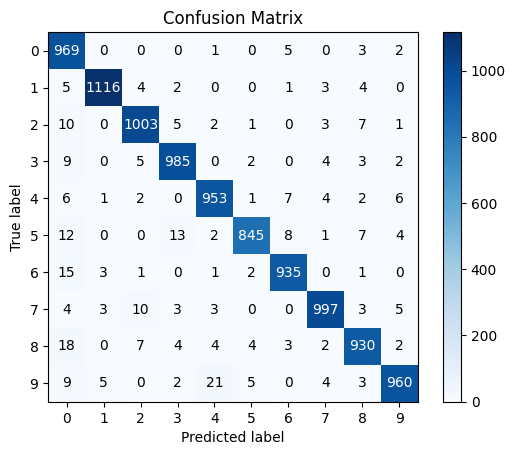

array([[ 969,    0,    0,    0,    1,    0,    5,    0,    3,    2],
       [   5, 1116,    4,    2,    0,    0,    1,    3,    4,    0],
       [  10,    0, 1003,    5,    2,    1,    0,    3,    7,    1],
       [   9,    0,    5,  985,    0,    2,    0,    4,    3,    2],
       [   6,    1,    2,    0,  953,    1,    7,    4,    2,    6],
       [  12,    0,    0,   13,    2,  845,    8,    1,    7,    4],
       [  15,    3,    1,    0,    1,    2,  935,    0,    1,    0],
       [   4,    3,   10,    3,    3,    0,    0,  997,    3,    5],
       [  18,    0,    7,    4,    4,    4,    3,    2,  930,    2],
       [   9,    5,    0,    2,   21,    5,    0,    4,    3,  960]])

In [27]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model_4.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names, fileidentity = "model4")

#### Model 5

We use the ReLU activation function, stochastic gradient descent and a learning rate of 0.001. One hidden layer of 64 nodes is used here. L1 and L2 regularisation (elastic-net) each of strength 0.001 is used.

Note that stochastic gradient descent is mini-batch gradient descent with a batch size of 1.

- Activation : ReLU
- Optimiser : Stochastic Gradient Descent
- Hidden layers : 1
- Epochs : 150
- Regularisation : L1 (Lasso) and L2 (Ridge)
- Learning rate : 0.001

In [28]:
dropout_rate = 0
activation_function = relu
num_epochs = 150
learning_rate = 0.001
optimizer = "mini_batch"
batch_size = 1
l1 = 0.001
l2 = 0.001

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, output_size]

##### Model 5 (Train)

In [29]:
# Define model and train neural network on training set

model_5 = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, l1 = l1, l2 = l2, random_state = randomer)
history_5 = model_5.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 100.0%, Loss after L1/L2: 0.0466
Epoch 1, Accuracy: 100.0%, Loss after L1/L2: 0.0471
Epoch 2, Accuracy: 100.0%, Loss after L1/L2: 0.0472
Epoch 3, Accuracy: 100.0%, Loss after L1/L2: 0.0468
Epoch 4, Accuracy: 100.0%, Loss after L1/L2: 0.0465
Epoch 5, Accuracy: 100.0%, Loss after L1/L2: 0.0463
Epoch 6, Accuracy: 100.0%, Loss after L1/L2: 0.0461
Epoch 7, Accuracy: 100.0%, Loss after L1/L2: 0.0457
Epoch 8, Accuracy: 100.0%, Loss after L1/L2: 0.0452
Epoch 9, Accuracy: 100.0%, Loss after L1/L2: 0.0447
Epoch 10, Accuracy: 100.0%, Loss after L1/L2: 0.0444
Epoch 11, Accuracy: 100.0%, Loss after L1/L2: 0.0444
Epoch 12, Accuracy: 100.0%, Loss after L1/L2: 0.0444
Epoch 13, Accuracy: 100.0%, Loss after L1/L2: 0.0443
Epoch 14, Accuracy: 100.0%, Loss after L1/L2: 0.0443
Epoch 15, Accuracy: 100.0%, Loss after L1/L2: 0.0442
Epoch 16, Accuracy: 100.0%, Loss after L1/L2: 0.0441
Epoch 17, Accuracy: 100.0%, Loss after L1/L2: 0.0439
Epoch 18, Accuracy: 100.0%, Loss after L1/L2: 0.0438
Epo

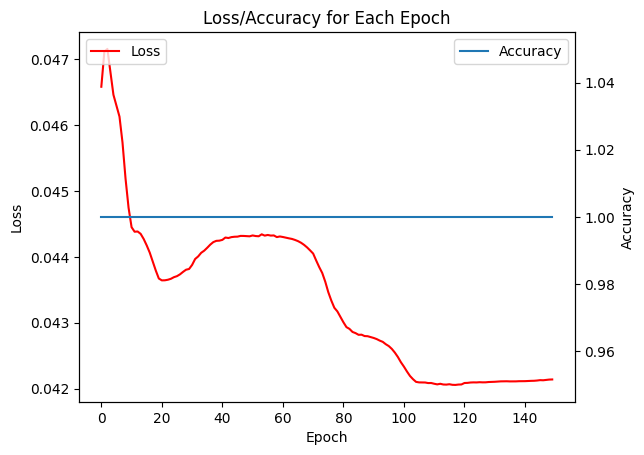

In [30]:
# Display loss and accuracy per epoch

# Loss
plt.plot(history_5[1], color = "red")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Accuracy
plt2 = plt.twinx()
plt2.plot(history_5[0])
plt.ylabel("Accuracy")
plt.title("Loss/Accuracy for Each Epoch")
plt2.legend(["Accuracy"], loc = "upper right")
plt.savefig("model_5.pdf")
plt.show()

##### Model 5 (Test)

In [31]:
# Test the neural network
predictions = model_5.predict(X_test)

# Calculate accuracy
accuracy = model_5.compute_accuracy(predictions, y_test_one_hot)
loss = model_5.compute_cost_with_regularisation(predictions, y_test_one_hot)[0]

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 90.69%
Loss: 0.7818


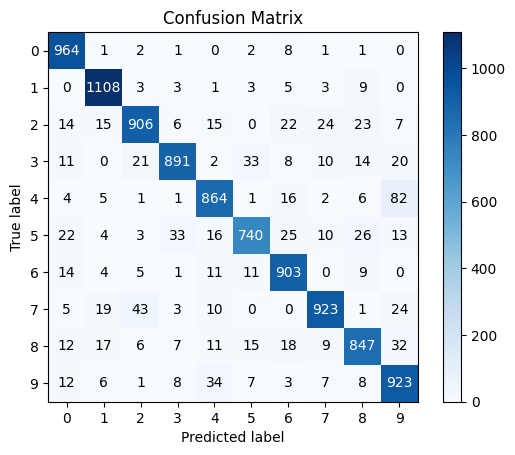

array([[ 964,    1,    2,    1,    0,    2,    8,    1,    1,    0],
       [   0, 1108,    3,    3,    1,    3,    5,    3,    9,    0],
       [  14,   15,  906,    6,   15,    0,   22,   24,   23,    7],
       [  11,    0,   21,  891,    2,   33,    8,   10,   14,   20],
       [   4,    5,    1,    1,  864,    1,   16,    2,    6,   82],
       [  22,    4,    3,   33,   16,  740,   25,   10,   26,   13],
       [  14,    4,    5,    1,   11,   11,  903,    0,    9,    0],
       [   5,   19,   43,    3,   10,    0,    0,  923,    1,   24],
       [  12,   17,    6,    7,   11,   15,   18,    9,  847,   32],
       [  12,    6,    1,    8,   34,    7,    3,    7,    8,  923]])

In [32]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model_5.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names, fileidentity = "model5")